# Portfolio Optimization

In [1]:
from pyfinlab import data_api as api
from pyfinlab import risk_models as risk
from pyfinlab import return_models as ret
from pyfinlab import portfolio_optimization as opt
from pyfinlab import performance as perf
from pyfinlab import report_generation as report
from pyfinlab import csv_file_generation as csv
from pyfinlab import backtesting as bkt
%matplotlib inline

## Introduction

Navigate to the data folder and open the 'portopt_inputs.xlsx' Excel file. The 'mapping' tab contains columns for the tickers, their names, multiple categories by which to classify each ticker, and ending with a MIN and MAX column where you set your ticker-level weighting constraints. The 'mapping' tab is used to map each category to each ticker allowing you to easily constrain both at the ticker-level and category-level. The other tabs contain the constraints for each of the categories contained in the 'mapping' tab as columns. They are region, size, style, credit, duration, asset_class, sec_type, holding, and sector. 

##### Category Definitions

* 'SIZE': Market cap size of common stocks and underlying holdings in equity ETFs.
    * example: large cap, mid cap, small cap
* 'SECTOR': Equity sector of common stocks and underlying holdings in equity ETFs.
    * example: technology, consumer staples, healthcare
* 'STYLE': Investment style of common stocks and underlying holdings in equity ETFs.
    * example: value, blend, growth
* 'REGION': Geographic region of all portfolio holdings.
    * example: U.S., Developed Markets, Emerging Markets
* 'HOLDING': Core versus satellite specification for common stocks and underlying holdings in equity ETFs.
    * example: core, satellite...helpful when managing a core/satellite strategy
* 'ASSET_CLASS': Asset class of all portfolio holdings.
    * example: equity, bond
* 'SECURITY_TYPE': Security type of all portfolio holdings.
    * example: common stocks, ETFs
* 'DURATION': Duration for bond ETF underlying holdings.
    * example: long, intermediate, short
* 'CREDIT': Credit quality of bond ETF underlying holdings.
    * example: high, mid, low

Choose an API source, either 'yfinance' which is free, or, 'bloomberg' which requires a Bloomberg Professional Service subscription. 

In [2]:
api_source = 'yfinance' # yfinance or bloomberg

Enter a title used to name the report file. 

In [3]:
title = 'github' # used to name file

Choose a risk model. Here are your choices. 

In [4]:
risk_models = [
    # PyPortfolioOpt
    'sample_cov',
    'semicovariance',
    'exp_cov',
    'ledoit_wolf_constant_variance',
    'ledoit_wolf_single_factor',
    'ledoit_wolf_constant_correlation',
    'oracle_approximating',

    # PortfolioLab
    'sample_covariance',
    'minimum_covariance_determinant',
    'empirical_covariance',
    'shrinked_covariance_basic',
    'shrinked_covariance_lw',
    'shrinked_covariance_oas',
    'semi_covariance',
    'exponential_covariance',
    'constant_residual_eigenvalues_denoised',
    'constant_residual_spectral_denoised',
    'targeted_shrinkage_denoised',
    'targeted_shrinkage_detoned',
    'constant_residual_detoned',
    'hierarchical_filtered_complete',
    'hierarchical_filtered_single',
    'hierarchical_filtered_avg'
]

In [5]:
risk_model = 'oracle_approximating' 

Choose a return model. Here are your choices. 

In [6]:
return_models = [
    # PyPortfolioOpt
    'simple_return',
    'avg_historical_return',
    'exponential_historical_return',

    # PortfolioLab
    'simple_return',
    'mean_historical_return',
    'exponential_historical_return'
]

In [7]:
return_model = 'ema_historical_return'

Enter the ticker symbol for your benchmark index.

In [8]:
benchmark_ticker = 'SPY'

How many years of price data do you want to use to optimize portfolios? The length of the price data will be equal to the number of days since inception of the youngest security in your ticker list up to the number you specify in num_years. 

In [9]:
num_years = 10

Gamma is an L2 regularisation, to increase the number of nonzero weights. Increasing this parameter forces the algorithm to increase the number of positions in each portfolio, thus, increasing diversification. Leave gamma at 0.0 if you do not want to use L2 regularisation. Typically, gamma can be anything and you might need to use trial and error to find the right gamma level. If using gamma, I recommend first trying anything from 0.01 to 1.0, and see what portfolios are created. Change gamma as needed. Please see https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/objective_functions.html#L2_reg for more information. 

In [10]:
gamma = 0.0 # Higher gamma increases portfolio diversification. 

You can also filter out tickers by using a restricted securities list (../data/restricted_securities.csv). 

In [11]:
restricted = False

Assign ticker list using the following steps. 

1) Type the tickers into column A of the "../data/portopt_inputs.xlsx" Excel spreadsheet. 
2) Drag the formulas so that they exactly match up with the tickers you typed into column A. 
3) Check if there are any blank rows after your tickers and delete if found.  

Your ticker column and the data columns should line up EXACTLY. There should also be no blank rows below your tickers. The other columns should populate with data from the "database" and "constraints" tabs using VLOOKUP functions. You need to make sure all your tickers have data.

In [12]:
tickers = opt.tickers

Choose start and end dates. 

In [13]:
start_date, end_date = api.start_end_dates(num_years, api_source)
print('Start Date: {}'.format(start_date))
print('End Date: {}'.format(end_date))

Start Date: 2011-10-02
End Date: 2021-09-29


Download price data and risk-free rate. 

In [14]:
prices = api.price_history(tickers, start_date, end_date, api_source, restricted=restricted)
risk_free_rate = api.risk_free_rate(prices.index[0], prices.index[-1], api_source)

[*********************100%***********************]  83 of 83 completed
[*********************100%***********************]  1 of 1 completed


Compute covariance matrix and expected return vector. 

In [15]:
cov_matrix = risk.risk_model(prices, risk_model)
exp_returns = ret.return_model(prices, return_model, risk_free_rate)

## Optimize a single portfolio given 10% target portfolio risk and display. 

Compute optimal portfolio.

In [16]:
target_volatility = 0.12 # choose target volatility and run
objective_function = 'efficient_risk'
optimized_portfolio, optimized_performance = opt.optimize_portfolio(
    exp_returns, cov_matrix,
    risk_model, return_model,
    objective_function,
    target_volatility, 
    restricted=restricted, 
    gamma=gamma
)
opt.display_portfolio(optimized_portfolio, optimized_performance)

                       PORTFOLIO
ema_historical_return     0.2327
oracle_approximating      0.1200
sharpe_ratio              1.7724


,NAME,REGION,HOLDING,SIZE,STYLE,SECTOR,SECURITY_TYPE,ASSET_CLASS,DURATION,CREDIT,WEIGHTING
TICKER,,,,,,,,,,,
TDTF,FlexShares iBoxx 5-Year Target Duration TIPS I...,U.S.,Satellite,,,,ETP,Fixed Income,Short-Term,Investment Grade,0.1913
QQQ,Invesco QQQ Trust Series 1,U.S.,Core,Large-cap,Growth,,ETP,Equity,,,0.1750
BSV,Vanguard Short-Term Bond ETF,U.S.,Core,,,,ETP,Fixed Income,Short-Term,Investment Grade,0.1626
TIP,iShares TIPS Bond ETF,U.S.,Core,,,,ETP,Fixed Income,,Investment Grade,0.1250
VIG,Vanguard Dividend Appreciation ETF,U.S.,Core,Large-cap,Value,,ETP,Equity,,,0.0824
IJH,iShares Core S&P Mid-Cap ETF,U.S.,Core,Mid-cap,Value,,ETP,Equity,,,0.0625
GBTC,Grayscale Bitcoin Trust BTC,Global,Core,,,Cryptocurrency,Open-End Fund,Specialty,,,0.0312
IJR,iShares Core S&P Small-Cap ETF,U.S.,Core,Small-cap,Value,,ETP,Equity,,,0.0312
REMX,VanEck Rare Earth/Strategic Metals ETF,Global,Satellite,Broad Market,Growth,Materials,ETP,Equity,,,0.0312


Available categories for grouping cash and risk allocations. 

In [17]:
groups = list(opt.classification.columns[1:])
print('Available Groups: {}'.format(groups))

Available Groups: ['REGION', 'HOLDING', 'SIZE', 'STYLE', 'SECTOR', 'SECURITY_TYPE', 'ASSET_CLASS', 'DURATION', 'CREDIT']


Print cash and risk allocation by weighting. 

In [18]:
group = 'ASSET_CLASS' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

              CASH_WTG
Fixed Income    0.5101
Equity          0.4285
Specialty       0.0312
REIT            0.0300
Commodity       0.0000
 
              RISK_WTG
Equity          0.7694
Specialty       0.1603
REIT            0.0515
Fixed Income    0.0189
Commodity       0.0000


In [19]:
group = 'SIZE' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

              CASH_WTG
Large-cap       0.2736
Mid-cap         0.0625
Broad Market    0.0612
Small-cap       0.0312
 
              RISK_WTG
Large-cap       0.4745
Broad Market    0.1196
Mid-cap         0.1166
Small-cap       0.0587


In [20]:
group = 'HOLDING' # Select a category to view portfolio exposure. 
cash_focus = opt.cash_focus(optimized_portfolio).get(group).rename(columns={'WEIGHTING': 'CASH_WTG'})
risk_focus = opt.risk_focus(optimized_portfolio, cov_matrix).get(group).rename(columns={'WEIGHTING': 'RISK_WTG'})
cash_focus = cash_focus.loc[cash_focus.index!=''].sort_values(by='CASH_WTG', ascending=False)
risk_focus = risk_focus.loc[risk_focus.index!=''].sort_values(by='RISK_WTG',ascending=False)
print(cash_focus)
print(' ')
print(risk_focus)

           CASH_WTG
Core         0.6999
Satellite    0.2999
 
           RISK_WTG
Core         0.8567
Satellite    0.1434


## Compute Efficient Frontier Portfolios

In [21]:
optimized_portfolios, results = opt.compute_efficient_frontier(
    exp_returns, cov_matrix, risk_model, return_model, restricted, gamma
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.27it/s]


Show efficient frontier portfolios cash weightings. 

In [22]:
optimized_portfolios.iloc[:, 10:].loc[~(optimized_portfolios.iloc[:, 10:]==0).all(axis=1)]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
TICKER,,,,,,,,,,,,,,,,,,,,
BNDX,0.1924,0.0627,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
BSV,0.5000,0.5000,0.5000,0.4642,0.4102,0.3488,0.2907,0.2312,0.1743,0.1113,0.0349,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
EWRE,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0074,0.0300
EWW,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0312
FMB,0.0683,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
GBTC,0.0000,0.0107,0.0198,0.0277,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312
IJH,0.0000,0.0000,0.0000,0.0122,0.0275,0.0470,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
IJR,0.0000,0.0000,0.0000,0.0061,0.0138,0.0235,0.0312,0.0312,0.0312,0.0312,0.0312,0.0338,0.0402,0.0462,0.0519,0.0610,0.0625,0.0625,0.0625,0.0625
IWD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1250


Show tickers that were removed due to being on the restricted securities list. 

In [23]:
optimized_portfolios.index.difference(cov_matrix.index)

Index([], dtype='object', name='TICKER')

Compute risk weightings. 

In [24]:
optimized_portfolios = optimized_portfolios[optimized_portfolios.index.isin(cov_matrix.index)]
risk_weightings = opt.risk_weightings(optimized_portfolios, cov_matrix)

Show the risk and return model inputs for the optimizer for each efficient frontier portfolio and the expected sharpe ratio. 

In [25]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
efficient_frontier,,,,,,,,,,,,,,,,,,,,
ema_historical_return,0.0470,0.0934,0.1210,0.1438,0.1644,0.1823,0.1990,0.2147,0.2296,0.2442,0.2585,0.2725,0.2860,0.2985,0.3104,0.3215,0.3325,0.3433,0.3531,0.3556
oracle_approximating,0.0295,0.0405,0.0516,0.0626,0.0736,0.0846,0.0957,0.1067,0.1177,0.1287,0.1398,0.1508,0.1618,0.1728,0.1839,0.1949,0.2059,0.2169,0.2280,0.2390
sharpe_ratio,0.9148,1.8132,1.9579,1.9777,1.9619,1.9187,1.8709,1.8243,1.7810,1.7417,1.7062,1.6745,1.6439,1.6114,1.5789,1.5471,1.5178,1.4903,1.4608,1.4045


Show the cash and risk weightings grouped by asset class. 

In [26]:
print('Available Groups: {}'.format(groups))

Available Groups: ['REGION', 'HOLDING', 'SIZE', 'STYLE', 'SECTOR', 'SECURITY_TYPE', 'ASSET_CLASS', 'DURATION', 'CREDIT']


In [27]:
group = 'ASSET_CLASS'
opt.cash_focus(optimized_portfolios).get(group)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Commodity,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Equity,0.0266,0.0824,0.1157,0.1325,0.1820,0.2448,0.3033,0.3613,0.4171,0.4704,0.5218,0.5758,0.6415,0.7068,0.7690,0.8201,0.8709,0.9082,0.9683,0.9685
Fixed Income,0.9620,0.8982,0.8469,0.8099,0.7562,0.6938,0.6353,0.5772,0.5215,0.4682,0.4169,0.3628,0.2972,0.2319,0.1696,0.1185,0.0678,0.0305,0.0000,0.0000
REIT,0.0000,0.0000,0.0158,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0300,0.0299,0.0300,0.0282,0.0000,0.0000
Specialty,0.0000,0.0107,0.0198,0.0277,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312,0.0312


In [28]:
opt.risk_focus(optimized_portfolios, cov_matrix).get(group)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Commodity,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Equity,0.0707,0.3054,0.3595,0.3567,0.4547,0.5727,0.6572,0.7172,0.7617,0.7936,0.8158,0.8403,0.8631,0.8796,0.8922,0.9023,0.9102,0.9177,0.9398,0.9433
Fixed Income,0.9293,0.5406,0.3046,0.1959,0.1265,0.0832,0.0538,0.0338,0.0209,0.0140,0.0125,0.0047,-0.0037,-0.0078,-0.0096,-0.0106,-0.0108,-0.0101,0.0000,0.0000
REIT,0.0000,0.0000,0.0502,0.0837,0.0746,0.0685,0.0624,0.0571,0.0524,0.0483,0.0447,0.0416,0.0392,0.0370,0.0349,0.0328,0.0311,0.0277,0.0000,0.0000
Specialty,0.0000,0.1540,0.2857,0.3637,0.3442,0.2757,0.2268,0.1919,0.1651,0.1441,0.1271,0.1134,0.1014,0.0912,0.0824,0.0754,0.0695,0.0647,0.0603,0.0568


Compute cash and risk weightings grouped by category for all efficient frontier portfolios. 

In [29]:
cash_focus = opt.compile_focus_stats(optimized_portfolios, cov_matrix, focus='cash')
risk_focus = opt.compile_focus_stats(optimized_portfolios, cov_matrix, focus='risk')

Display cash weightings grouped by category for all efficient portfolios. 

In [30]:
cash_focus

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Cash Weighting,,,,,,,,,,,,,,,,,,,,
Developed Markets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0462
Emerging Markets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0312
Emerging Markets Local Currency,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Global,0.0131,0.0419,0.0510,0.0589,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624,0.0624
U.S.,0.9755,0.9494,0.9472,0.9412,0.9370,0.9374,0.9374,0.9373,0.9374,0.9374,0.9375,0.9374,0.9375,0.9375,0.9374,0.9373,0.9375,0.9357,0.9305,0.8599
Core,0.6983,0.6913,0.6983,0.7001,0.7000,0.6999,0.6999,0.6998,0.6999,0.6999,0.7000,0.6999,0.7000,0.7000,0.7000,0.6999,0.7000,0.7000,0.6995,0.6999
Satellite,0.2903,0.3000,0.2999,0.3000,0.2994,0.2999,0.2999,0.2999,0.2999,0.2999,0.2999,0.2999,0.2999,0.2999,0.2998,0.2998,0.2999,0.2981,0.3000,0.2998
Broad Market,0.0207,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0612,0.0899,0.2174
Large-cap,0.0059,0.0212,0.0545,0.0530,0.0795,0.1131,0.1484,0.2064,0.2622,0.3155,0.3669,0.4131,0.4597,0.5070,0.5521,0.5758,0.6222,0.6595,0.6909,0.5636


Display risk weightings grouped by category for all efficient portfolios. 

In [31]:
risk_focus

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Risk Weighting,,,,,,,,,,,,,,,,,,,,
Developed Markets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0372
Emerging Markets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0056,0.0269
Emerging Markets Local Currency,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Global,0.0481,0.3301,0.4316,0.4848,0.4523,0.3725,0.3137,0.2705,0.2365,0.2093,0.1869,0.1689,0.1533,0.1399,0.1280,0.1184,0.1101,0.1031,0.0969,0.0926
U.S.,0.9519,0.6699,0.5684,0.5152,0.5477,0.6276,0.6865,0.7295,0.7636,0.7907,0.8132,0.8311,0.8467,0.8601,0.8719,0.8815,0.8899,0.8969,0.8976,0.8434
Core,0.5997,0.5141,0.6319,0.7040,0.7470,0.7802,0.8092,0.8333,0.8530,0.8687,0.8810,0.8897,0.8510,0.7954,0.7441,0.7457,0.7602,0.7734,0.7493,0.7332
Satellite,0.4003,0.4859,0.3681,0.2960,0.2530,0.2199,0.1910,0.1667,0.1471,0.1313,0.1191,0.1103,0.1490,0.2046,0.2558,0.2542,0.2398,0.2266,0.2508,0.2669
Broad Market,0.0623,0.2574,0.2249,0.1907,0.1742,0.1595,0.1453,0.1329,0.1218,0.1120,0.1034,0.0963,0.0906,0.0855,0.0804,0.0761,0.0720,0.0683,0.0880,0.2011
Large-cap,0.0084,0.0480,0.1346,0.1183,0.1770,0.2448,0.3029,0.3913,0.4617,0.5167,0.5594,0.5893,0.5994,0.6067,0.6136,0.6054,0.6238,0.6450,0.6563,0.5522


Plot efficient frontier with individual assets and save image to charts folder. 

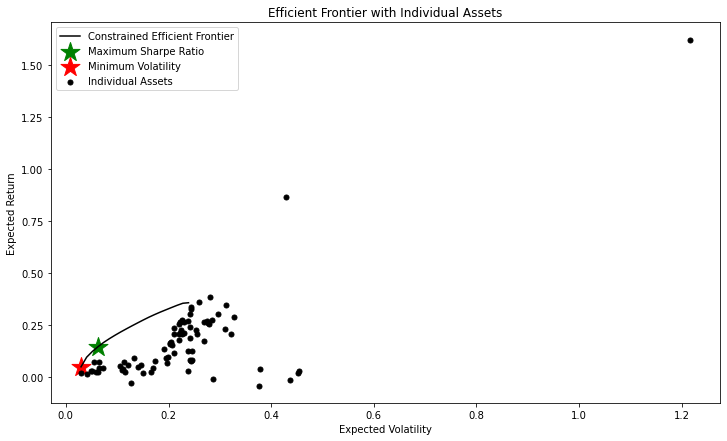

In [32]:
opt.eff_frontier_plot(cov_matrix, exp_returns, results, figsize=(12, 7), save=False, show=True)

Plot monte carlo efficient frontier with random portfolios and save image to charts folder. 

C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\25del\Anaconda3\envs\pyfinlab\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


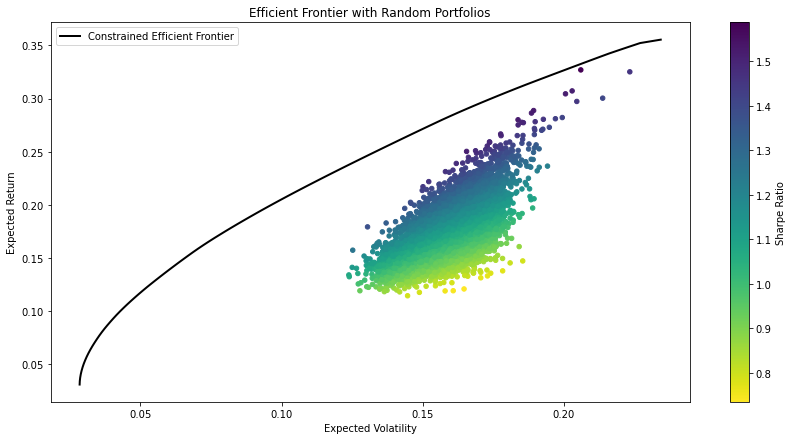

In [33]:
opt.monte_carlo_frontier(
    cov_matrix, exp_returns, figsize=(12, 6), save=False, show=True, restricted=restricted, gamma=gamma)

Top 10 securities by average weighting across all 20 efficient frontier portfolios. 

In [34]:
weightings = optimized_portfolios.iloc[:, 10:]
print('Available Portfolios: {}'.format(list(weightings.columns)))

Available Portfolios: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [35]:
weightings.sum(axis=1).sort_values(ascending=False).head(10) / 20

TICKER
BSV     0.178280
QQQ     0.145140
TDTF    0.132835
TIP     0.093340
VIG     0.078685
PSET    0.070800
IJH     0.048085
IJR     0.034125
REMX    0.030295
PHO     0.028880
dtype: float64

# Backtest Algorithm

The following wrapper functions use the bt Python financial backtesting library. 

In [36]:
benchmark_backtest = bkt.benchmark_backtest(benchmark_ticker, start_date, end_date, api_source)

[*********************100%***********************]  1 of 1 completed


In [37]:
portfolio_backtests = bkt.compile_backtests(weightings, prices)

In [38]:
Results = bkt.run_backtest(portfolio_backtests, benchmark_backtest)

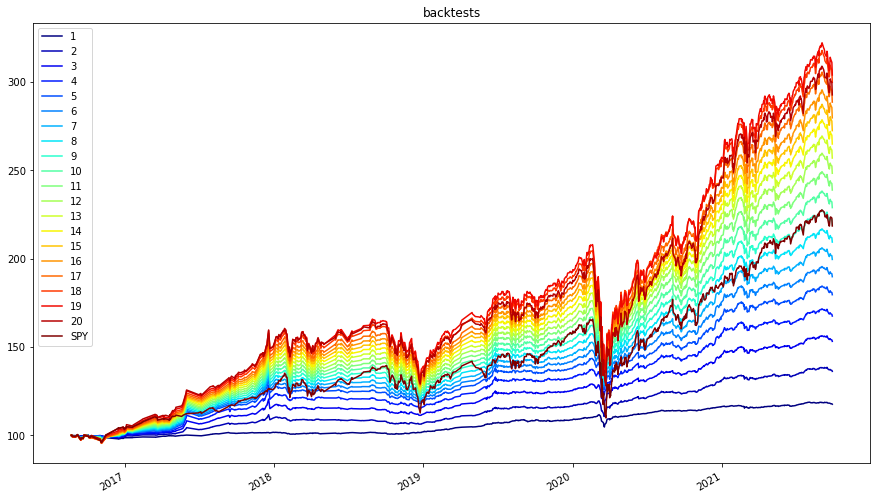

In [39]:
bkt.linechart(Results, save=False, show=True)

Create a dataframe of portfolio values over time. 

In [40]:
backtest_timeseries = bkt.backtest_timeseries(Results, freq='d')
backtest_timeseries.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,SPY
2016-08-23,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,219.777665
2016-08-24,99.921908,99.801934,99.699732,99.610381,99.553993,99.512818,99.476602,99.447962,99.420483,99.393712,...,99.341969,99.337441,99.341563,99.345631,99.329133,99.311065,99.311849,99.337634,99.252661,218.653531
2016-09-01,99.817064,99.610381,99.470168,99.355572,99.288221,99.274186,99.252535,99.208445,99.166063,99.124041,...,99.045437,99.029955,99.020773,99.012198,98.992888,98.966843,99.049427,99.118118,99.137753,218.191835
2016-09-06,100.033912,100.034660,100.068210,100.086861,100.097276,100.110340,100.119235,100.110840,100.102703,100.093733,...,100.077615,100.050588,100.013650,99.978440,99.972080,99.966740,100.050763,100.160409,100.474865,219.837877
2016-09-14,99.524649,99.290086,99.211563,99.132077,99.020192,98.758074,98.547619,98.397274,98.252343,98.104668,...,97.821973,97.680130,97.527003,97.381604,97.285527,97.205085,97.260055,97.460951,97.569924,213.936256


Wrapper function which creates a dataframe of performance statistics using the ffn Python library. 

In [41]:
perf_data = Results.perf_data()
perf_data

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,SPY
Start,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,...,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22,2016-08-22
End,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,...,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28,2021-09-28
Risk-free rate,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
,,,,,,,,,,,...,,,,,,,,,,
Total Return,17.60%,36.21%,53.18%,67.49%,79.58%,89.78%,99.54%,109.36%,119.11%,128.88%,...,148.31%,156.91%,164.87%,172.43%,179.69%,188.58%,199.76%,203.92%,192.67%,118.47%
Daily Sharpe,1.71,2.01,1.99,1.91,1.89,1.89,1.86,1.83,1.80,1.77,...,1.70,1.66,1.62,1.58,1.54,1.51,1.50,1.44,1.35,1.09
Daily Sortino,2.63,3.32,3.26,3.13,3.07,3.03,2.97,2.90,2.84,2.78,...,2.66,2.59,2.52,2.45,2.39,2.35,2.33,2.24,2.07,1.67
CAGR,3.23%,6.25%,8.72%,10.64%,12.16%,13.38%,14.50%,15.59%,16.62%,17.63%,...,19.52%,20.32%,21.04%,21.71%,22.34%,23.09%,24.02%,24.35%,23.43%,16.56%
Max Drawdown,-6.26%,-7.41%,-8.88%,-10.57%,-12.35%,-14.02%,-15.57%,-16.90%,-18.17%,-19.46%,...,-22.01%,-23.68%,-25.91%,-28.04%,-29.76%,-31.21%,-32.67%,-34.86%,-36.02%,-33.72%
Calmar Ratio,0.52,0.84,0.98,1.01,0.99,0.95,0.93,0.92,0.92,0.91,...,0.89,0.86,0.81,0.77,0.75,0.74,0.74,0.70,0.65,0.49


# Compute Performance Statistics

Create a dictionary of performance statistics by period lengths in days. 

In [42]:
backtest_statistics = perf.compile_performance_stats(
    backtest_timeseries, risk_model, benchmark_ticker, risk_free_rate)

These are the time periods that were backtested. 

In [43]:
backtested_periods = perf.backtested_periods(backtest_statistics)
print('Periods Backtested: {}'.format(list(backtested_periods.keys())))

Periods Backtested: ['1WK', '1MO', '3MO', '6MO', '1YR', '3YR']


Look up any time period's performance statistics. 

In [44]:
time_period = '3YR' # choose from the list of time periods above. 
backtest_statistics[backtested_periods.get(time_period)]

,vol,beta,cagr,drawdown,capm,jensen_alpha,m2,m2_alpha,sharpe,treynor,sortino,info_ratio,capture_ratio,appraisal_ratio,ulcer
02-23-2018 - 09-28-2021,,,,,,,,,,,,,,,
1,0.0263,0.0310,0.0525,-0.0097,0.0060,0.0466,0.4632,0.2727,1.9988,1.6978,2.1975,-0.0418,0.7931,1.8445,0.8036
2,0.0388,0.0777,0.0776,-0.0165,0.0148,0.0628,0.4629,0.2723,1.9976,0.9986,2.3793,-0.0367,1.0453,1.8243,0.7674
3,0.0512,0.1325,0.0984,-0.0200,0.0252,0.0732,0.4451,0.2546,1.9211,0.7428,2.2755,-0.0326,1.1058,1.7842,0.7175
4,0.0626,0.1717,0.1138,-0.0239,0.0327,0.0811,0.4208,0.2302,1.8159,0.6626,2.1425,-0.0292,1.0859,1.6747,0.6298
5,0.0737,0.2264,0.1276,-0.0265,0.0431,0.0845,0.4012,0.2107,1.7315,0.5637,2.0223,-0.0265,1.0979,1.6318,0.5854
6,0.0844,0.2825,0.1427,-0.0293,0.0538,0.0888,0.3916,0.2011,1.6902,0.5050,1.9552,-0.0233,1.1001,1.6670,0.5746
7,0.0953,0.3374,0.1559,-0.0318,0.0643,0.0916,0.3790,0.1885,1.6359,0.4621,1.8823,-0.0201,1.0960,1.6809,0.5519
8,0.1064,0.3947,0.1678,-0.0344,0.0752,0.0926,0.3657,0.1751,1.5782,0.4252,1.8069,-0.0170,1.0884,1.7069,0.5354
9,0.1175,0.4502,0.1791,-0.0368,0.0858,0.0934,0.3532,0.1627,1.5244,0.3980,1.7427,-0.0135,1.0813,1.7247,0.5214


# Historical Periodic Performance Statistics

Create a dictionary of periodic performance statistics by statistic. 

In [45]:
periodic_stats = perf.compile_periodic_stats(backtest_timeseries, backtest_statistics, backtested_periods)

In [46]:
print('Available Stats: {}'.format(perf.available_keys(backtest_statistics, backtested_periods)))

Available Stats: ['vol', 'beta', 'cagr', 'drawdown', 'capm', 'jensen_alpha', 'm2', 'm2_alpha', 'sharpe', 'treynor', 'sortino', 'info_ratio', 'capture_ratio', 'appraisal_ratio', 'ulcer']


Lookup any available periodic statistic by key. 

In [47]:
key = 'vol'
periodic_stats[key]

,1WK,1MO,3MO,6MO,1YR,3YR
vol,,,,,,
1,0.0010,0.0042,0.0076,0.0116,0.0185,0.0263
2,0.0033,0.0087,0.0152,0.0206,0.0346,0.0388
3,0.0048,0.0111,0.0190,0.0254,0.0454,0.0512
4,0.0058,0.0132,0.0225,0.0299,0.0552,0.0626
5,0.0074,0.0153,0.0258,0.0344,0.0640,0.0737
6,0.0091,0.0173,0.0285,0.0388,0.0718,0.0844
7,0.0106,0.0192,0.0311,0.0432,0.0793,0.0953
8,0.0121,0.0209,0.0335,0.0470,0.0861,0.1064
9,0.0135,0.0226,0.0359,0.0508,0.0928,0.1175


# Excel Report Generation

Generate and save backtest and efficient frontier plots as png files. 

In [48]:
bkt.linechart(Results, figsize=(13, 8), save=True, show=False)
opt.eff_frontier_plot(
    cov_matrix, exp_returns, results, figsize=(13, 8), save=True, show=False)
opt.monte_carlo_frontier(
    cov_matrix, exp_returns, figsize=(12, 7), save=True, show=False, restricted=restricted, gamma=gamma)

C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\25del\Anaconda3\envs\pyfinlab\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Generate fully formatted Excel file. 

In [49]:
report.generate_excel_report(
    optimized_portfolios, risk_weightings, results, backtest_timeseries, cash_focus, risk_focus, periodic_stats, title)

# Performance Tracker

In [50]:
holdings_prices = prices[list(weightings.loc[~(weightings==0).all(axis=1)].index)]

In [51]:
print('Top Winners: 1 Day Return')
((holdings_prices.iloc[-1] / holdings_prices.iloc[-2] - 1).sort_values(ascending=False).head(20) * 100).round(2).astype(str) + '%'

Top Winners: 1 Day Return


REZ     -0.02%
TDTF    -0.04%
BSV     -0.04%
BNDX    -0.21%
TIP     -0.22%
FMB     -0.35%
PLD     -0.48%
VCIT    -0.48%
EWRE    -0.49%
VTV      -1.1%
IWD     -1.24%
IJR     -1.42%
IJH     -1.56%
VIG      -1.6%
PSET    -1.82%
KRMA    -1.92%
VO      -2.03%
ZROZ    -2.25%
PHO     -2.33%
VGK     -2.35%
dtype: object

In [52]:
print('Top Losers: 1 Month Return')
((holdings_prices.iloc[-1] / holdings_prices.iloc[-22] - 1).sort_values(ascending=True).head(20) * 100).round(2).astype(str) + '%'

Top Losers: 1 Month Return


GBTC    -16.4%
REMX    -7.14%
PHO     -5.37%
VGK     -4.99%
VGT     -4.65%
ZROZ    -4.62%
PSET    -4.45%
QQQ     -4.19%
PLD     -3.91%
VIG     -3.87%
KRMA    -3.83%
REZ     -3.28%
VO      -3.21%
VTV     -3.08%
EWRE    -3.07%
IJH     -3.06%
EWW     -2.82%
IWD     -2.66%
IJR     -1.74%
BNDX    -1.37%
dtype: object